## ML HW3 sample code

#### Import packages

In [131]:
import os
import random
import glob
import csv
import torch
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image

#### Set arguments and random seed

In [3]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
# DEVICE_ID = 2
SEED = 5566


# torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Process data

In [4]:
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 
    4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

def get_train_label_and_image(label_path):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'data/train/{i+7000}.jpg' for i in range(len(train_label))]
    return train_image, train_label

def load_partial_data(train_image_path, train_label):
    train_data = list(zip(train_image_path, train_label))
    data = []
    path = []
    label_list = []
    label_dict = dict()
    for (img_path, label) in train_data:
        label_dict[label] = 0

    for (img_path, label) in train_data:
        if label_dict[label] == 5:
            continue
        else:
            label_dict[label] += 1
            data.append(np.array(Image.open(img_path)))
            label_list.append(label)
            path.append(img_path)

        if sum(label_dict.values()) == 35:
            break

    X_train = np.array(data)
    y_train = np.array(label_list)
    return X_train, y_train, path

def load_train_data(label_path):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'data/train/{i+7000}.jpg' for i in range(len(train_label))]
    train_data = list(zip(train_image, train_label))
    data = []
    label_list = []
    for (path, label) in train_data:
        data.append(np.array(Image.open(path)))
        label_list.append(train_label)
    X_train = np.array(data)
    y_train = np.array(label_list)
    return X_train, y_train
    

def load_test_data():
    data = []
    test_set = [f'data/test/{i}.jpg' for i in range(7000)]
    for path in test_set:
        data.append(np.array(Image.open(path)))
    X_test = np.array(data)
    return X_test
    
def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

def compute_category_distribution(train_set, emotion_cat):
    emotion = dict()
    for idx, label in emotion_cat.items():
        emotion[label] = 0
    for (img_path, label) in train_set:
        emotion[emotion_cat[label]] += 1
    return emotion

# EDA

In [5]:
train_image_path, train_label = get_train_label_and_image(LABEL_PATH)
X_train_partial, y_train_partial, path = load_partial_data(train_image_path, train_label)
print(X_train_partial.shape)
print(y_train_partial.shape)
#data_partial = np.concatenate([X_train_partial, y_train_partial], axis = 2)

(35, 64, 64)
(35,)


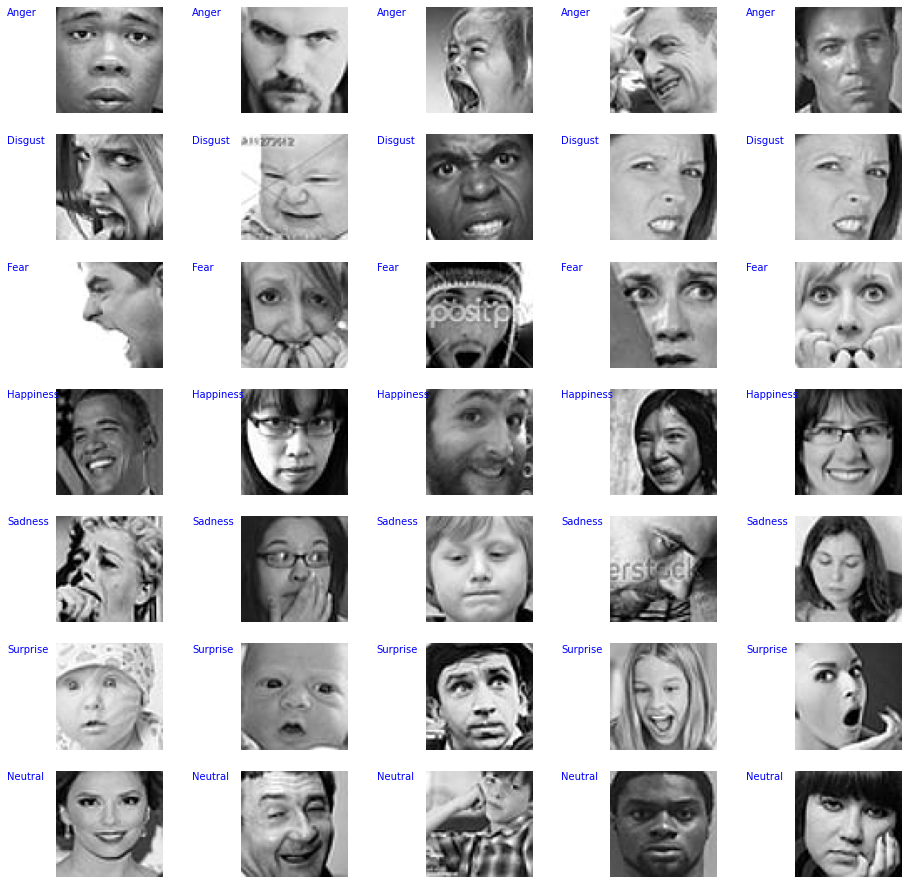

In [18]:
plt.rcParams["figure.figsize"] = [16,16]
row = 0
for emotion_idx, emotion_label in emotion_cat.items():
    print(f"Label: {emotion_label}")
    image_idx_arr = np.where(y_train_partial == emotion_idx)[0]
    count = 0
    for image_idx in image_idx_arr:
        img = X_train_partial[image_idx]
        print(path[image_idx])
        plt.subplot(7,5, row+count+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(emotion_label), fontsize=10, color='b')
        plt.axis('off')
        count += 1
    row += 5
plt.show()

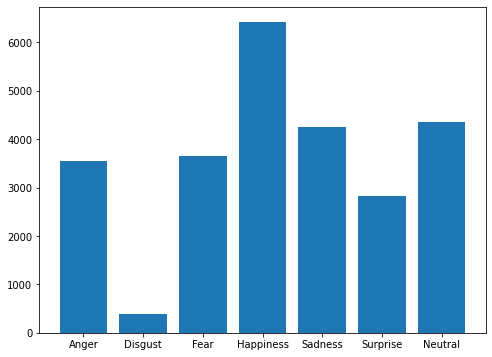

In [21]:
emotion_dist = compute_category_distribution(train_set, emotion_cat)
emotion_label_list = emotion_dist.keys()
emotion_count = emotion_dist.values()
plt.figure(figsize=(8,6))
plt.bar(emotion_label_list, emotion_count)
plt.show()

# Data Preprocessing

In [19]:
X_train, y_train = load_train_data(LABEL_PATH)
X_test = load_test_data()

In [ ]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_test', X_test)

In [7]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.array(train_label)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(28887, 64, 64)
(28887,)
(7000, 64, 64)


In [43]:
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tr = transform(X_train)
img_np = np.array(img_tr)
mean_img = np.mean(img_np)
std_img = np.std(img_np)
print(f"Mean of all image is {mean_img}")
print(f"Std of all image is {std_img}")

Mean of all image is 0.5081561803817749
Std of all image is 0.2644411027431488


# Dataset

In [118]:
class FaceExpressionDataset(Dataset):
    def __init__(self, X, y, augment=None):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)
    
    def read_img(self, idx):
        # img = Image.open(self.data[idx][0])
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(img)
        img = img.unsqueeze(0).float()
        #print(img.shape)
        #img = self.normalize(img)
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.y[idx]
        return img, label
    
class TestingDataset(Dataset):
    def __init__(self, X, augment=None):
        self.X = X
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def read_img(self, idx):
        # img = Image.open(self.data[idx])
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(img).float()
        img = img.unsqueeze(0).float()
        #print(img.shape)
        #img = self.normalize(img)
        return img
        
    def __getitem__(self, idx):
        img = self.read_img(idx)
        return img

In [119]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

train_dataset = FaceExpressionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = FaceExpressionDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TestingDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)                  

In [120]:
#make sure stratified result
print(pd.Series(y_train).value_counts() / y_train.shape[0])
print(pd.Series(y_valid).value_counts() / y_valid.shape[0])

3    0.251970
6    0.171433
4    0.167493
2    0.143274
0    0.138751
5    0.111468
1    0.015611
dtype: float64
3    0.251641
6    0.171554
4    0.167615
2    0.143107
0    0.138731
5    0.111597
1    0.015755
dtype: float64


In [121]:
#Check dimension
for (img, label) in train_dataset:
    print(img.shape) #(Channel, height, width)
    break

torch.Size([1, 64, 64])


#### Define module class

In [86]:
"""
Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)
"""
def conv_output_shape(h, w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((w + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [90]:
h_FM1, w_FM1 = conv_output_shape(64, 64, kernel_size=5, stride=1, pad=2, dilation=1)
print(f"Dimension of feature map 1 after conv1 is ({w_FM1}, {h_FM1})")

Dimension of feature map 1 after conv1 is (64, 64)


In [127]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()
        self.conv = nn.Sequential(
            #input size: 64 x 64
            #P = (F-1)/2, F: filter size
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding=2), #64 x 64 x 32 channels
            nn.BatchNorm2d(num_features = 32, eps=1e-05, affine=True), #learnable parameters
            nn.LeakyReLU(negative_slope=0.05),
            #Apply 2 x 2 max pooling, with stride = 2
            nn.MaxPool2d(kernel_size = 2), #output size (32 x 32) x 32 channels   
        )
        self.fc = nn.Sequential(
            nn.Linear(32768, 256),
            nn.ReLU(),
            torch.nn.Dropout(0.3),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        #image size (64,64)
        x = self.conv(x) #(batch_size, channel, height, width)
        x = x.flatten(start_dim=1) #(batch_size, channel * height * width)
        x = self.fc(x)
        return x

#### Define training and testing process

In [133]:
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()            
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
    #average over all batches
    train_acc = np.mean(train_acc)
    train_loss = np.mean(train_loss)
    return train_acc, train_loss
    
    
def valid(valid_loader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc
    #average over all batches
    valid_acc = np.mean(valid_acc)
    valid_loss = np.mean(valid_loss)
    return valid_acc, valid_loss

def save_checkpoint(model, prefix='model'):
    checkpoint_path = f'{prefix}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    #print('model saved to %s' % checkpoint_path)

In [135]:
NUM_ECPOCH = 30
model = FaceExpressionNet()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

acc_record = []
best_valid_acc = 0
best_valid_loss = 0
best_epoch = 0
no_update_cnt = 0
patience = 5
x = time.time()
for epoch in range(NUM_ECPOCH):
    train_acc, train_loss = train(train_loader, model, loss_fn, optimizer, device)
    valid_acc, valid_loss = valid(valid_loader, model, loss_fn, device)
    acc_record.append(valid_acc)
    if valid_acc > best_valid_acc:
        save_checkpoint(model, prefix='model')
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        no_update_cnt = 0
    else:
        no_update_cnt += 1
    y = time.time()
    time_train = (y - x) / 60
    print(f"Epoch {epoch}: {round(time_train, 3)} min elapsed, train acc: {round(train_acc * 100, 4)}%, train loss: {round(train_loss, 3)}, valid acc: {round(valid_acc * 100, 4)}%, valid loss: {round(valid_loss, 3)}")
    #Early stop
    if no_update_cnt > patience:
        break

print('########################################################')
print("Finish model tuning")
print(f"Best epoch is {best_epoch}, Accuracy: {best_valid_acc}, Loss: {best_valid_loss}")

Epoch0, 1.2 min elapsed, train acc: 22.3%, train loss:3.457, valid acc: 25.82%, valid loss:1.789
Epoch1, 2.43 min elapsed, train acc: 26.029999999999998%, train loss:1.775, valid acc: 31.730000000000004%, valid loss:1.72
Epoch2, 3.63 min elapsed, train acc: 27.07%, train loss:1.724, valid acc: 32.95%, valid loss:1.661
Epoch3, 4.82 min elapsed, train acc: 30.680000000000003%, train loss:1.682, valid acc: 34.839999999999996%, valid loss:1.662
Epoch4, 6.02 min elapsed, train acc: 32.82%, train loss:1.633, valid acc: 36.5%, valid loss:1.602
Epoch5, 7.23 min elapsed, train acc: 33.47%, train loss:1.614, valid acc: 38.21%, valid loss:1.608
Epoch6, 8.42 min elapsed, train acc: 35.53%, train loss:1.568, valid acc: 37.2%, valid loss:1.582
Epoch7, 9.63 min elapsed, train acc: 36.97%, train loss:1.542, valid acc: 36.24%, valid loss:1.609
Epoch8, 10.83 min elapsed, train acc: 37.26%, train loss:1.538, valid acc: 40.44%, valid loss:1.56
Epoch9, 12.03 min elapsed, train acc: 38.42%, train loss:1.488

In [ ]:
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        for idx, img in enumerate(test_loader):
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
        
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

In [ ]:
test(test_loader, model)